# Data Preparation and loading 

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    average_precision_score,
    f1_score
)

fraud_df = pd.read_csv("../data/processed/fraud_processed.csv")

target = "class"

num_features = [
    "purchase_value",
    "age",
    "hour_of_day",
    "day_of_week",
    "time_since_signup",
    "transactions_per_user"
]

cat_features = [
    "source",
    "browser",
    "sex",
    "country"
]

X = fraud_df[num_features + cat_features]
y = fraud_df[target]

fraud_df.head()


,user_id,purchase_value,device_id,source,browser,sex,age,class,country,hour_of_day,day_of_week,time_since_signup,transactions_per_user
0,22058,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,0,Japan,2,5,4506682.0,1
1,333320,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,0,United States,1,0,17944.0,1
2,1359,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,1,United States,18,3,1.0,1
3,150084,44,ATGTXKYKUDUQN,SEO,Safari,M,41,0,Unknown,13,0,492085.0,1
4,221365,39,NAUITBZFJKHWW,Ads,Safari,M,45,0,United States,18,2,4361461.0,1


 # Stratified Train-Test Split

In [2]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


# Preprocessing Pipeline

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)

X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)




# Baseline Logistic Regression

In [4]:
lr_fraud = LogisticRegression(
    max_iter=1000,
    class_weight="balanced"
)

lr_fraud.fit(X_train_proc, y_train)

y_pred = lr_fraud.predict(X_test_proc)
y_prob = lr_fraud.predict_proba(X_test_proc)[:, 1]


# Evaluation

In [5]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("PR-AUC:", average_precision_score(y_test, y_prob))
print("F1:", f1_score(y_test, y_pred))


[[17670  9723]
 [  868  1962]]
              precision    recall  f1-score   support

           0       0.95      0.65      0.77     27393
           1       0.17      0.69      0.27      2830

    accuracy                           0.65     30223
   macro avg       0.56      0.67      0.52     30223
weighted avg       0.88      0.65      0.72     30223

PR-AUC: 0.3931339759898802
F1: 0.2703410265242852


# Ensemble Model – Random Forest + SMOTE

In [6]:
smote = SMOTE(random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(
    X_train_proc, y_train
)

rf_fraud = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)

rf_fraud.fit(X_train_smote, y_train_smote)

y_pred_rf = rf_fraud.predict(X_test_proc)
y_prob_rf = rf_fraud.predict_proba(X_test_proc)[:, 1]


# Evalution

In [7]:
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print("PR-AUC:", average_precision_score(y_test, y_prob_rf))
print("F1:", f1_score(y_test, y_pred_rf))


[[27375    18]
 [ 1338  1492]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     27393
           1       0.99      0.53      0.69      2830

    accuracy                           0.96     30223
   macro avg       0.97      0.76      0.83     30223
weighted avg       0.96      0.96      0.95     30223

PR-AUC: 0.6251386993746142
F1: 0.687557603686636


# Model Comparison

In [8]:
from sklearn.metrics import precision_recall_curve, roc_curve
import matplotlib.pyplot as plt


# Logistic Regression
y_prob_lr_fraud = lr_fraud.predict_proba(X_test_proc)[:, 1]

# Random Forest
y_prob_rf_fraud = rf_fraud.predict_proba(X_test_proc)[:, 1]


# Precision–Recall Curve (Fraud Data)

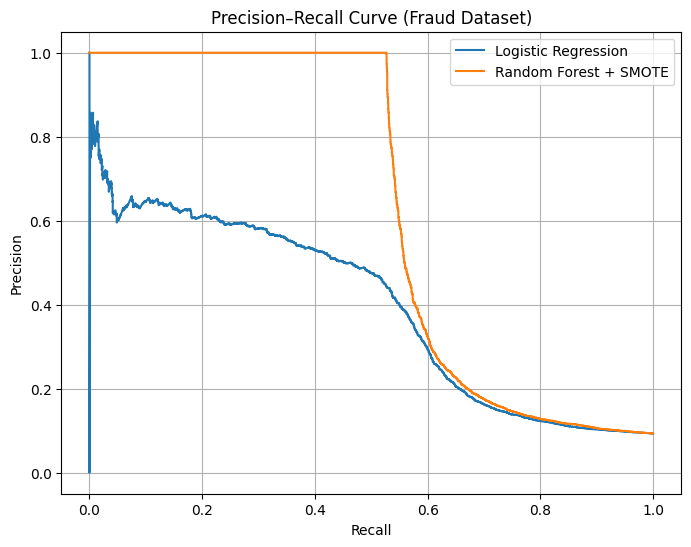

In [9]:
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_prob_lr_fraud)
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_prob_rf_fraud)

plt.figure(figsize=(8, 6))
plt.plot(recall_lr, precision_lr, label="Logistic Regression")
plt.plot(recall_rf, precision_rf, label="Random Forest + SMOTE")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Fraud Dataset)")
plt.legend()
plt.grid(True)
plt.show()


# ROC Curve (Fraud Data)

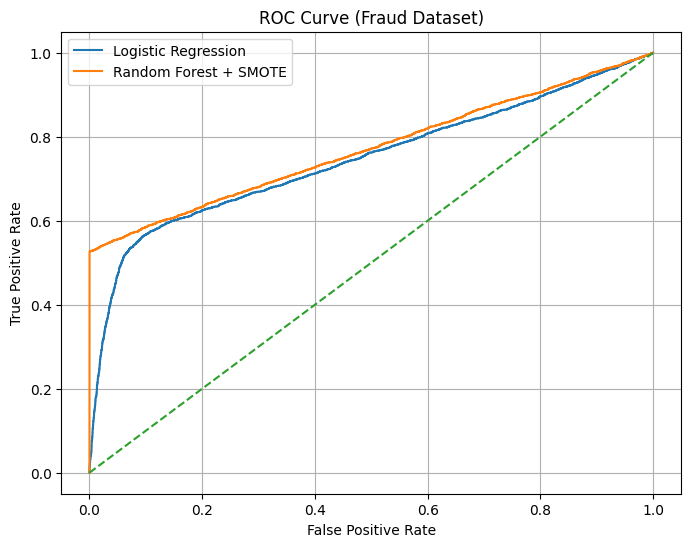

In [10]:
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr_fraud)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf_fraud)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label="Logistic Regression")
plt.plot(fpr_rf, tpr_rf, label="Random Forest + SMOTE")
plt.plot([0, 1], [0, 1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Fraud Dataset)")
plt.legend()
plt.grid(True)
plt.show()


# Numeric Comparison Table (Fraud Data)

In [11]:
comparison_fraud = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest + SMOTE"],
    "PR-AUC": [
        average_precision_score(y_test, y_prob_lr_fraud),
        average_precision_score(y_test, y_prob_rf_fraud)
    ],
    "F1-Score": [
        f1_score(y_test, lr_fraud.predict(X_test_proc)),
        f1_score(y_test, rf_fraud.predict(X_test_proc))
    ]
})

comparison_fraud


,Model,PR-AUC,F1-Score
0,Logistic Regression,0.393134,0.270341
1,Random Forest + SMOTE,0.625139,0.687558


# Feature Importance (Baseline Explanation)

In [ ]:
feature_names = preprocessor.get_feature_names_out()

importance_fraud = pd.DataFrame({
    "feature": feature_names,
    "importance": rf_fraud.feature_importances_
}).sort_values(by="importance", ascending=False)


In [ ]:
plt.figure(figsize=(8, 6))
plt.barh(importance_fraud.head(10)["feature"],
         importance_fraud.head(10)["importance"])
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances (Fraud RF)")
plt.xlabel("Importance")
plt.show()


# Setting Up SHAP

In [ ]:
import shap
shap.initjs()


# Create SHAP Explainer

In [ ]:
explainer_fraud = shap.TreeExplainer(rf_fraud)
shap_values_fraud = explainer_fraud.shap_values(X_test_proc)
shap.summary_plot(
    shap_values_fraud[1],
    X_test_proc,
    feature_names=feature_names
)
importance_cc = pd.DataFrame({
    "feature": feature_names,
    "importance": rf_fraud.feature_importances_
}).sort_values(by="importance", ascending=False)
plt.figure(figsize=(8, 6))
plt.barh(importance_cc.head(10)["feature"], importance_cc.head(10)["importance"])
plt.gca().invert_yaxis()


# SHAP Summary Plot (GLOBAL EXPLANATION)

In [ ]:
shap.summary_plot(
    shap_values_fraud[1],
    X_test_proc,
    feature_names=feature_names
)


# Selecting Individual Cases

In [ ]:
y_pred = rf_fraud.predict(X_test_proc)
plt.figure(figsize=(8, 6))
plt.barh(importance_cc.head(10)["feature"], importance_cc.head(10)["importance"])
plt.gca().invert_yaxis()


In [ ]:


tp = np.where((y_test == 1) & (y_pred == 1))[0][0]
fp = np.where((y_test == 0) & (y_pred == 1))[0][0]
fn = np.where((y_test == 1) & (y_pred == 0))[0][0]


# SHAP Force Plots (LOCAL EXPLANATIONS)

# True Positive (Correct Fraud)

In [ ]:
shap.force_plot(
    explainer_fraud.expected_value[1],
    shap_values_fraud[1][tp],
    X_test_proc[tp],
    feature_names=feature_names
)
plt.figure(figsize=(8, 6))
plt.barh(importance_cc.head(10)["feature"], importance_cc.head(10)["importance"])
plt.gca().invert_yaxis()



# False Positive (Legitimate Flagged)

In [ ]:
shap.force_plot(
    explainer_fraud.expected_value[1],
    shap_values_fraud[1][fp],
    X_test_proc[fp],
    feature_names=feature_names
)

importance_cc = pd.DataFrame({
    "feature": feature_names,
    "importance": rf_fraud.feature_importances_
}).sort_values(by="importance", ascending=False)
plt.figure(figsize=(8, 6))
plt.barh(importance_cc.head(10)["feature"], importance_cc.head(10)["importance"])
plt.gca().invert_yaxis()



# False Negative (Missed Fraud)

In [ ]:
shap.force_plot(
    explainer_fraud.expected_value[1],
    shap_values_fraud[1][fn],
    X_test_proc[fn],
    feature_names=feature_names
)
plt.figure(figsize=(8, 6))
plt.barh(importance_cc.head(10)["feature"], importance_cc.head(10)["importance"])
plt.gca().invert_yaxis()
